In [2]:
# -----------------------------
# Imports & Setup
# -----------------------------
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import logging
from pathlib import Path
import sys


project_root = Path.cwd().resolve().parent 
sys.path.append(str(project_root))

from src.data.loader import FraudDataLoader
from src.transformation_and_imbalance import FraudDataTransformer
from src.utils.io_utils import save_dataframe

sns.set_theme(style="whitegrid")
pd.set_option("display.max_columns", 50)

logging.basicConfig(level=logging.INFO, format="%(asctime)s [%(levelname)s] %(message)s")
logger = logging.getLogger("Data_Transformation_Fraud")


In [3]:
# -----------------------------
# Load Feature Engineered data
# -----------------------------
fraud_loader = FraudDataLoader("../data/processed/fraud_data_with_features.csv")

fraud_df = fraud_loader.load()

logger.info(f"Feature Fraud data shape: {fraud_df.shape}")
logger.info(f"Feature Fraud  data columns: {fraud_df.columns}")

INFO:Data_Transformation_Fraud:Feature Fraud data shape: (151112, 17)
INFO:Data_Transformation_Fraud:Feature Fraud  data columns: Index(['purchase_time', 'user_id', 'signup_time', 'purchase_value',
       'device_id', 'source', 'browser', 'sex', 'age', 'ip_address', 'class',
       'country', 'hour_of_day', 'day_of_week', 'time_since_signup',
       'transactions_per_user', 'transactions_last_24h'],
      dtype='object')


INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


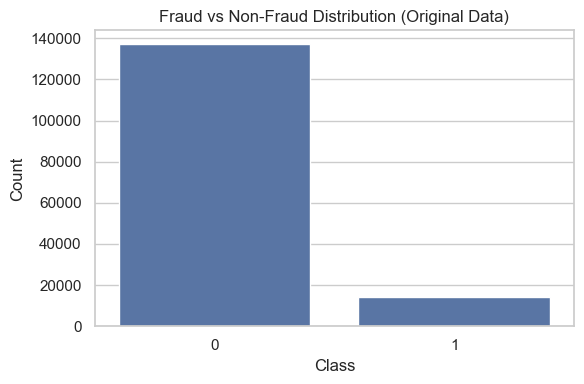

In [4]:
plt.figure(figsize=(6, 4))
sns.countplot(x="class", data=fraud_df)
plt.title("Fraud vs Non-Fraud Distribution (Original Data)")
plt.xlabel("Class")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


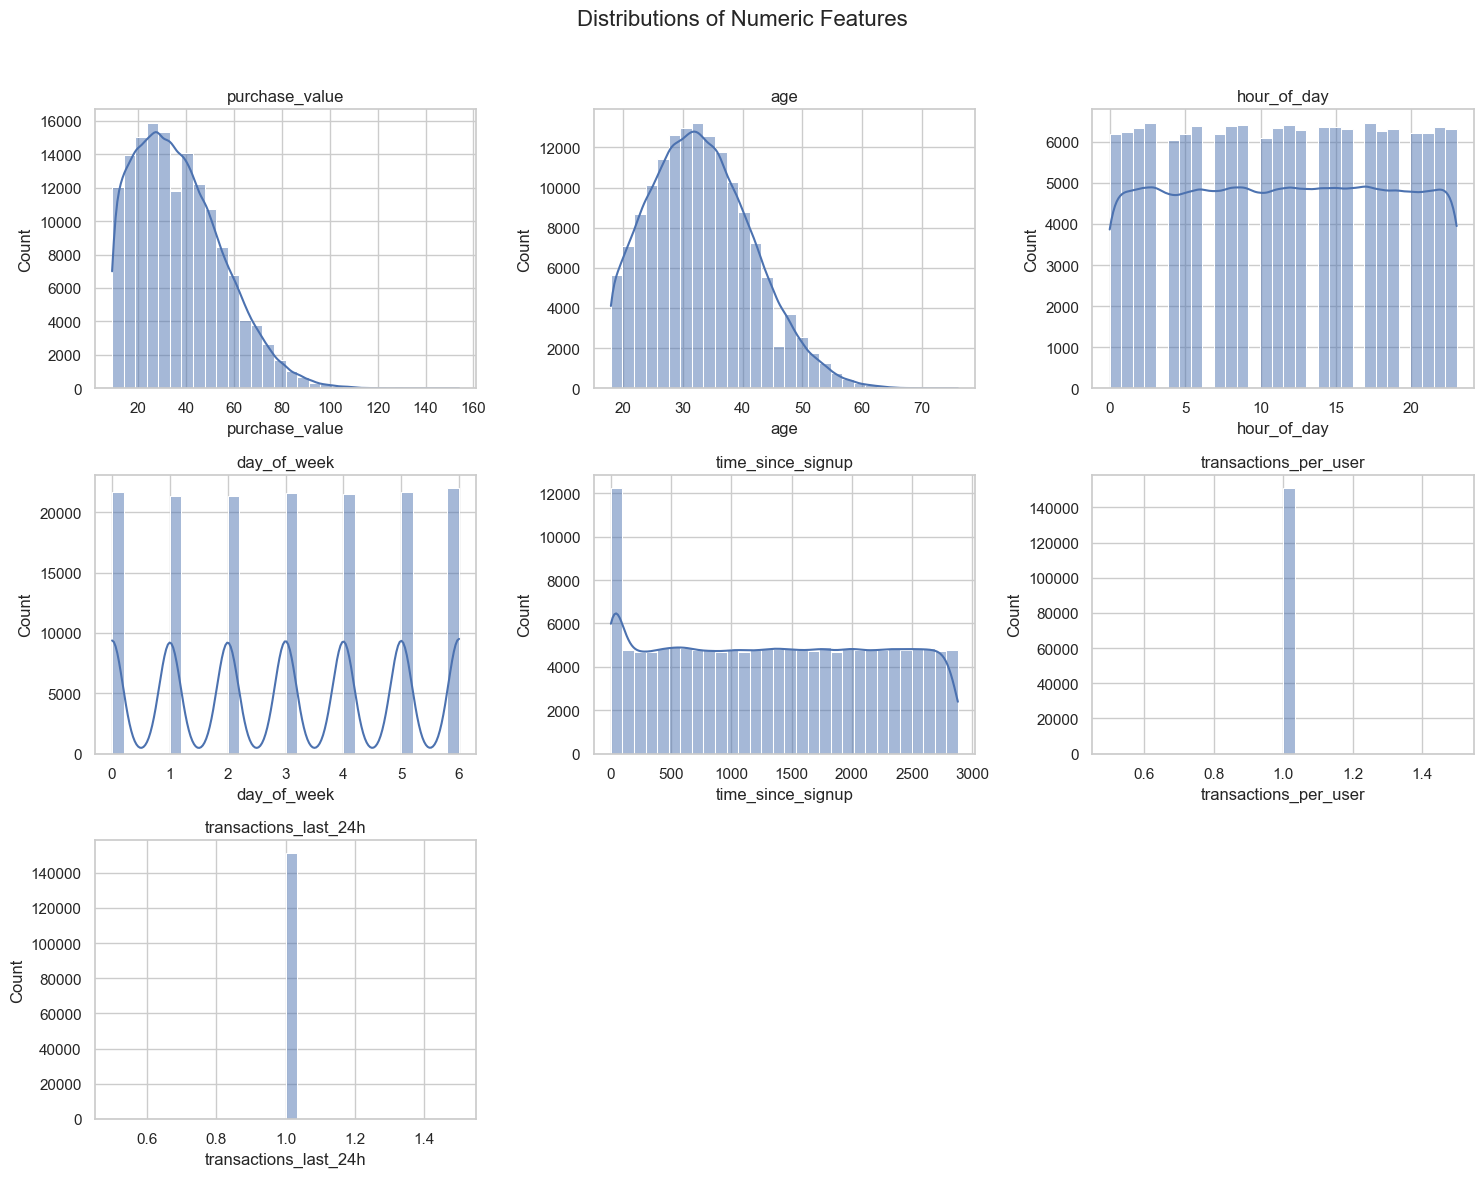

In [6]:
NUMERIC_FEATURES = [
    'purchase_value',
    'age',
    'hour_of_day',
    'day_of_week',
    'time_since_signup',
    'transactions_per_user',
    'transactions_last_24h'
]

n_cols = 3
n_rows = (len(NUMERIC_FEATURES) + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4 * n_rows))
axes = axes.flatten()

for i, col in enumerate(NUMERIC_FEATURES):
    sns.histplot(
        fraud_df[col],
        bins=30,
        kde=True,
        ax=axes[i]
    )
    axes[i].set_title(f"{col}")

# Remove empty subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.suptitle("Distributions of Numeric Features", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


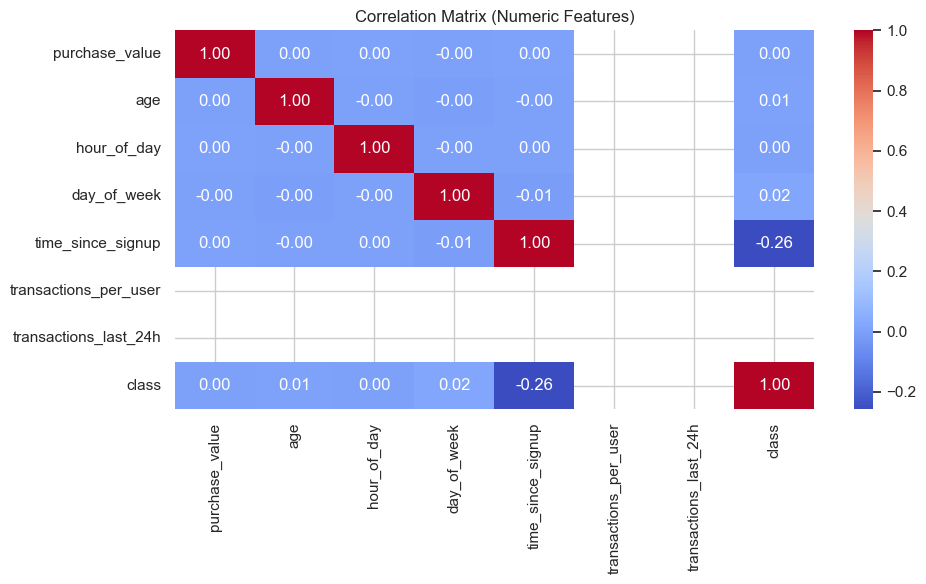

In [7]:
plt.figure(figsize=(10, 6))
corr = fraud_df[NUMERIC_FEATURES + ['class']].corr()
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Matrix (Numeric Features)")
plt.tight_layout()
plt.show()


In [8]:
CATEGORICAL_FEATURES = ['source', 'browser', 'sex', 'country']
TARGET = 'class'

transformer = FraudDataTransformer(
    fraud_df,
    target=TARGET,
    numeric_features=NUMERIC_FEATURES,
    categorical_features=CATEGORICAL_FEATURES
)


INFO:src.transformation_and_imbalance:Initialized FraudDataTransformer with 151112 rows


In [9]:
transformer.split_data()
X_train, X_test, y_train, y_test = transformer.get_train_test()

logger.info(f"Train shape: {X_train.shape}")
logger.info(f"Test shape: {X_test.shape}")

logger.info(f"Train set size: {X_train.shape[0]}")
logger.info(f"Test set size: {X_test.shape[0]}")

logger.info(f"Train class distribution:\n{y_train.value_counts()}")
logger.info(f"Test class distribution:\n{y_test.value_counts()}")



INFO:src.transformation_and_imbalance:Splitting data into train/test sets
INFO:src.transformation_and_imbalance:Train size: 120889, Test size: 30223
INFO:Data_Transformation_Fraud:Train shape: (120889, 11)
INFO:Data_Transformation_Fraud:Test shape: (30223, 11)
INFO:Data_Transformation_Fraud:Train set size: 120889
INFO:Data_Transformation_Fraud:Test set size: 30223
INFO:Data_Transformation_Fraud:Train class distribution:
class
0    109568
1     11321
Name: count, dtype: int64
INFO:Data_Transformation_Fraud:Test class distribution:
class
0    27393
1     2830
Name: count, dtype: int64


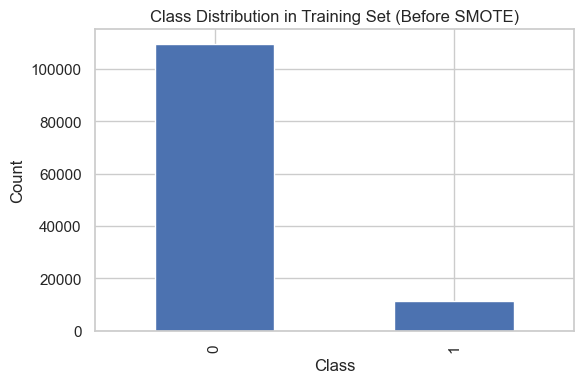

In [10]:
plt.figure(figsize=(6, 4))
y_train.value_counts().plot(kind="bar")
plt.title("Class Distribution in Training Set (Before SMOTE)")
plt.xlabel("Class")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


In [11]:
transformer.transform_features()
X_train, X_test, y_train, y_test = transformer.get_train_test()

print("Transformed X_train shape:", X_train.shape)
print("Transformed X_test shape:", X_test.shape)


INFO:src.transformation_and_imbalance:Transforming features: scaling numeric, encoding categorical
INFO:src.transformation_and_imbalance:Fitting and transforming training data
INFO:src.transformation_and_imbalance:Features transformed successfully


Transformed X_train shape: (120889, 196)
Transformed X_test shape: (30223, 196)


In [12]:
y_before_smote = y_train.copy()

transformer.handle_imbalance(strategy='SMOTE')
X_train, X_test, y_train, y_test = transformer.get_train_test()

print("After SMOTE, class distribution in training data:")
print(pd.Series(y_train).value_counts())


INFO:src.transformation_and_imbalance:Applying SMOTE to handle class imbalance on training data
INFO:src.transformation_and_imbalance:After SMOTE: Class distribution:
class
0    109568
1    109568
Name: count, dtype: int64


After SMOTE, class distribution in training data:
class
0    109568
1    109568
Name: count, dtype: int64


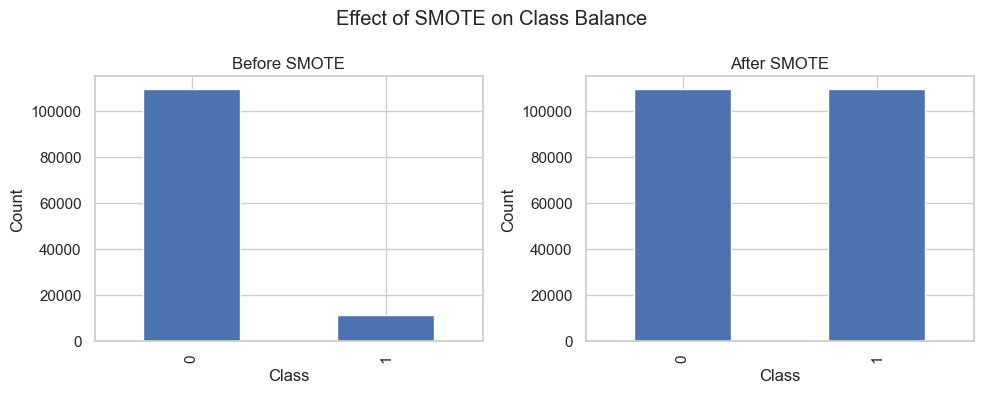

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

y_before_smote.value_counts().plot(
    kind="bar", ax=axes[0], title="Before SMOTE"
)
pd.Series(y_train).value_counts().plot(
    kind="bar", ax=axes[1], title="After SMOTE"
)

for ax in axes:
    ax.set_xlabel("Class")
    ax.set_ylabel("Count")

plt.suptitle("Effect of SMOTE on Class Balance")
plt.tight_layout()
plt.show()


In [14]:
train_df = pd.DataFrame(X_train)
train_df[TARGET] = y_train.values

save_dataframe(train_df, "../data/processed/fraud_train_smote.csv")
logger.info("Saved SMOTE-balanced training dataset")


INFO:Data_Transformation_Fraud:Saved SMOTE-balanced training dataset


[IO] Data saved to ..\data\processed\fraud_train_smote.csv
